In [1]:
# Generates the MNIST examples in the paper "Eikonal depth: an optimal 
# control approach to statistical depths" by:
# Martin Molina-Fructuoso
# Ryan Murray

import numpy as np
import scipy as sp
from numpy import linalg as la
import matplotlib.pyplot as plt

import graphlearning as gl

data_dic = np.load("MNIST_data.npz",allow_pickle=True)
data = data_dic['data']

labels_dic = np.load("MNIST_labels.npz",allow_pickle=True)
labels = labels_dic['labels']

In [2]:
# DEN_EST=False : The boundary is the digits with a different label
# DEN_EST=True : The boundary is defined using density estimation
DEN_EST=False

In [3]:
if DEN_EST==False:
    print("The boundary was defined as the digits with a different label")
    np.random.seed(4)

    points_selection=np.random.permutation(70000)
    points=data[points_selection]
    points_labels=labels[points_selection]

    # n is the number of points in the domain (included the boundary)
    n=points.shape[0]

    # Selects the points on the boundary
    in_boundary=1*(points_labels!=4)
else:
    print("The boundary was defined using density estimation")
    # # Selects some points for the domain
    np.random.seed(3)

    points_selection=np.random.permutation(70000)
    points=data[points_selection]
    points_labels=labels[points_selection]

    points=points[points_labels==4]

    n=points.shape[0]

    # Find boundaries in the set of numbers with the same label
    #Build Graph (sparse k-nearest neighbor graph)
    k=n
    I,J,D = gl.knnsearch_annoy(points,k)
    wght_mat = gl.weight_matrix(I,J,D,k)
    sparse_graph=1*(wght_mat>0) 

    # the guaranteed scanned radius is any radius less than
    np.min(np.amax(D,axis=1))

    # this counts the number of points inside a ball
    histo_count=np.sum(1*(D<5.75),axis=1)

    # Selects the points at the boundary
    in_boundary=1*(histo_count==1)

    boundary_points=points[(histo_count==1)]

    plt.figure(figsize=(10,10))
    gl.image_grid(boundary_points,n_rows=3,n_cols=8)
    plt.savefig(fname='boundarysample',bbox_inches='tight',dpi=300)
    plt.show()

The boundary was defined as the digits with a different label


In [4]:
# F is the inverse of the density
f=np.ones((n,1))
F=np.reciprocal(f)
# How F is defined on the boundary
F[np.nonzero(in_boundary)]=0

#Build Graph (sparse k-nearest neighbor graph)
k=10
I,J,D = gl.knnsearch_annoy(points,k)
wght_mat = gl.weight_matrix(I,J,D,k)
sparse_graph=1*(wght_mat>0) 

kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [5]:
values = 100*np.ones(n)

#Initialize the solved set/list/values
solved_list = np.nonzero(in_boundary)[0]
solved_set = set(solved_list)
values[solved_list] = 0.

max_solved = 0.

from scipy.sparse import find

#Initialize the considered set
considered_set = set()
for i in solved_list:
    neighbors = set(find(sparse_graph[i,:])[1])
    considered_set = considered_set.union(neighbors.difference(solved_set))
update_set = considered_set

#Create a list so that neighbor_set_list[i] = {Neighbors of i}
neighbor_set_list = []
for i in range(n):
    neighbor_set_list.append(set(find(sparse_graph[i,:])[1]))
k = len(solved_set)


while considered_set:
    
    #This is a progress indicator
    if k%100 == 0:
        print("{:.2f} %".format(k/n*100),end='\r')
    k += 1
    
    
    #Letting num_iter be small after some burn-in period.
    if k > 100:
        num_iter = 1
    new_max_solved = 1000.
    new_max_solved_index = -1

    for i in update_set:
        neighbors = neighbor_set_list[i]
        solved_neighbors = list(neighbors.intersection(solved_set))  
        neighbor_weights = wght_mat[i,solved_neighbors].toarray()[0]
        neighbor_values = values[solved_neighbors]
        allneighbors_weights = wght_mat[i,list(neighbors)].toarray()[0]
            
        values[i] = (neighbor_values.dot(neighbor_weights) + np.sqrt(neighbor_values.dot(neighbor_weights)**2 - np.sum(neighbor_weights)*((neighbor_values**2).dot(neighbor_weights) - 0.03**2* np.sum(allneighbors_weights)**2)))/np.sum(neighbor_weights)
    
    #Here we use update set to track places in the considered set where values need to be updates (i.e. there is a new solved neighbor)
    l = list(considered_set)
    min_index = l[np.argmin(values[l])]
    solved_set.add(min_index)
    solved_list = list(solved_set)
    considered_set.remove(min_index)
    update_set = neighbor_set_list[min_index].difference(solved_set)
    considered_set = considered_set.union(update_set)


print("Calculations complete")

Calculations complete


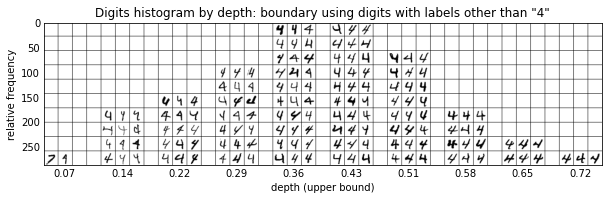

In [6]:
n_levels=10
levels=np.linspace(values.min(),values.max(),n_levels+1)

n_solved=n-np.sum(in_boundary)
hist_height=10
hist_colwidth=3
hist_padding=1
hist_width=(n_levels*hist_colwidth)+(n_levels-1)
hist=np.zeros((hist_height*(n_levels*hist_colwidth)+hist_height*(n_levels-1),points.shape[1]))
# this should be hist_height but using a multiple is better for visualization
if DEN_EST==False:
    hist_ndigits=45
else:
    hist_ndigits=40
    
for i in np.arange(n_levels):
    points_atlevel=points[(values>levels[i])&(values<=levels[i+1])]
    hist_val=int(np.ceil(hist_ndigits*points_atlevel.shape[0]/n_solved))
    print((hist_val>hist_height)*'Warning: A column in the histogram has been truncated')
    hist_val=np.minimum(hist_val,hist_height)  
    for j in np.arange(hist_val):  
        if (points_atlevel.shape[0]!=0):
            for k in np.arange(hist_colwidth):
                if j+k*hist_val < points_atlevel.shape[0]:
                    hist[hist_height*(hist_colwidth+hist_padding)*i+k*hist_height+j,:]=points_atlevel[j+k*hist_val,:]
  
    
    
def hist_show(X,n_rows=10,n_cols=10,padding=2,figname='MNISThist_generic.png', title="MNIST Histogram"):
    n = X.shape[0]
    m = X.shape[1]
    im_width = int(np.sqrt(m))
    X=np.reshape(X,(n,im_width,im_width))
    
    I = np.ones(((n_rows-1)*padding+n_rows*im_width,(n_cols-1)*padding+n_cols*im_width))
    
    c=0
    for i in range(n_cols):      
        col_pos = i*(im_width+padding)
        for j in np.flip(range(n_rows)):
            row_pos = j*(im_width+padding)
            if c < n:
                im = X[c,:,:].T
                I[row_pos:row_pos+im_width, col_pos:col_pos+im_width] = im
                c += 1
    
    plt.figure(figsize=(10,10))
    plt.imshow(1-I,cmap='gray')
    plt.xlabel('depth (upper bound)')
    plt.ylabel('relative frequency')
    plt.title(title)
    plt.tick_params(axis='both', labelsize=10, length = 0)
    plt.xticks(ticks=0.5*(hist_colwidth*28)+((hist_colwidth+hist_padding)*(28+padding))*np.arange(n_levels),labels=np.around(levels[1::],decimals=2))
    plt.savefig(figname,bbox_inches='tight',dpi=300)
    plt.show()


if DEN_EST==False:
    hist_show(hist,n_rows=hist_height,n_cols=hist_width,padding=1,figname='MNISThist.png',
             title='Digits histogram by depth: boundary using digits with labels other than "4"')
else:
    hist_show(hist,n_rows=hist_height,n_cols=hist_width,padding=1,figname='MNISThistboundary.png',
             title='Digits histogram by depth: boundary using density estimation')
